# ОИАД. Лабораторная работа №3

https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset?resource=download

## 1. Подготовка данных
1. проверить наличие пропусков и выбросов
2. привести категориальные признаки к числовым
3. вычислить парные корреляции признаков

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)

## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно

## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

# 1) Fetch and prepare data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/7S/OIIAI/insurance_train.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/7S/OIIAI/insurance_test.csv')
print("Размер обучающей выборки:", train_df.shape)
print("Размер тестовой выборки:", test_df.shape)

print("\nTrain head:")
print(train_df.head())
print("\nTest head:")
print(test_df.head())

Размер обучающей выборки: (338, 7)
Размер тестовой выборки: (1000, 7)

Train head:
   age     sex     bmi  children smoker     region      charges
0   26    male  27.060         0    yes  southeast  17043.34140
1   58    male  36.955         2    yes  northwest  47496.49445
2   20  female  24.420         0    yes  southeast  26125.67477
3   51  female  38.060         0    yes  southeast  44400.40640
4   62  female  25.000         0     no  southwest  13451.12200

Test head:
   age     sex     bmi  children smoker     region      charges
0   61    male  38.380         0     no  northwest  12950.07120
1   59  female  34.800         2     no  southwest  36910.60803
2   31    male  30.875         0     no  northeast   3857.75925
3   24  female  33.345         0     no  northwest   2855.43755
4   31    male  28.500         5     no  northeast   6799.45800


Train: Skipped values check...
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Test: Skipped values check...
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


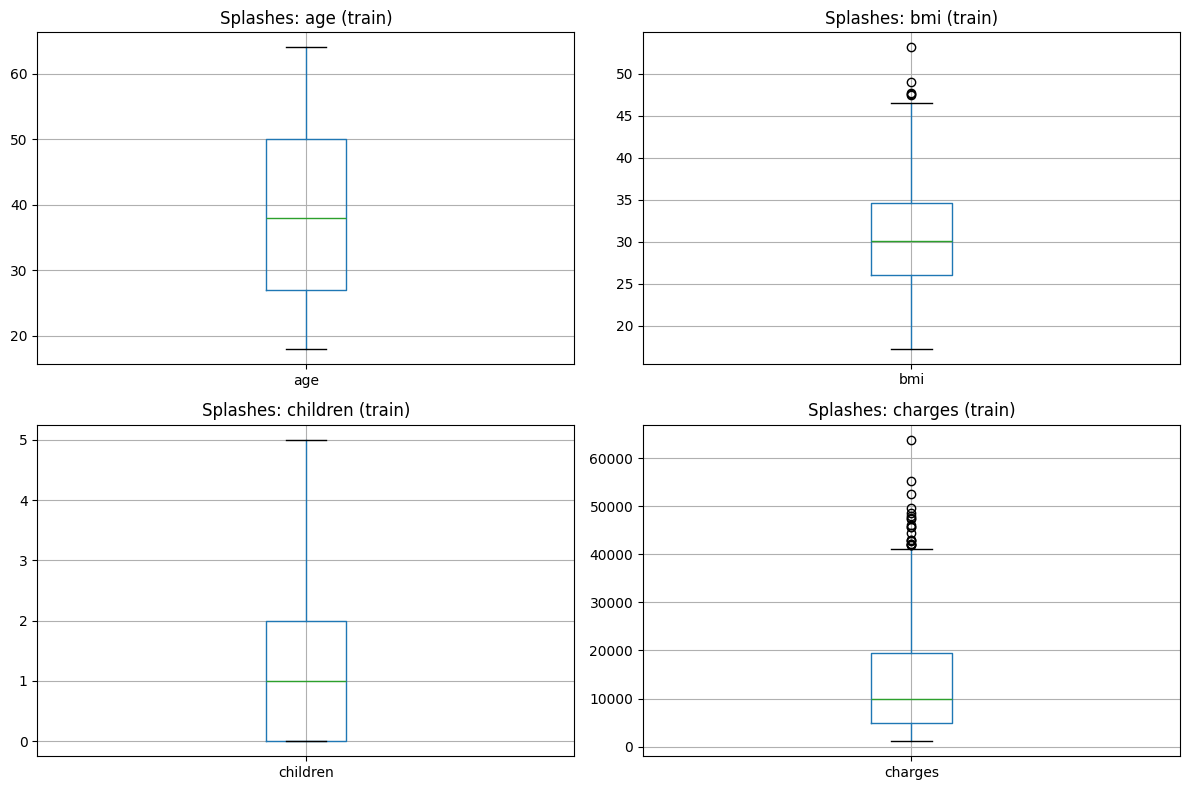

In [ ]:
print("Train: Skipped values check...")
print(train_df.isnull().sum())

print("\nTest: Skipped values check...")
print(test_df.isnull().sum())

numeric_columns = ['age', 'bmi', 'children', 'charges']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(numeric_columns):
    ax = axes[i//2, i%2]
    train_df.boxplot(column=col, ax=ax)
    ax.set_title(f'Splashes: {col} (train)')
plt.tight_layout()
plt.show()

In [ ]:
# Embedding for text features
print("Categorues, before embedding:")
categorical_columns = ['sex', 'smoker', 'region']

for col in categorical_columns:
    print(f"{col}: train - {train_df[col].unique()}, test - {test_df[col].unique()}")


label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    le.fit(train_df[col])
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

print("\nAfter embedding::")
print("Train:")
print(train_df.head())
print("\nTest:")
print(test_df.head())

Categorues, before embedding:
sex: train - ['male' 'female'], test - ['male' 'female']
smoker: train - ['yes' 'no'], test - ['no' 'yes']
region: train - ['southeast' 'northwest' 'southwest' 'northeast'], test - ['northwest' 'southwest' 'northeast' 'southeast']

After embedding::
Train:
   age  sex     bmi  children  smoker  region      charges
0   26    1  27.060         0       1       2  17043.34140
1   58    1  36.955         2       1       1  47496.49445
2   20    0  24.420         0       1       2  26125.67477
3   51    0  38.060         0       1       2  44400.40640
4   62    0  25.000         0       0       3  13451.12200

Test:
   age  sex     bmi  children  smoker  region      charges
0   61    1  38.380         0       0       1  12950.07120
1   59    0  34.800         2       0       3  36910.60803
2   31    1  30.875         0       0       0   3857.75925
3   24    0  33.345         0       0       1   2855.43755
4   31    1  28.500         5       0       0   6799.4580

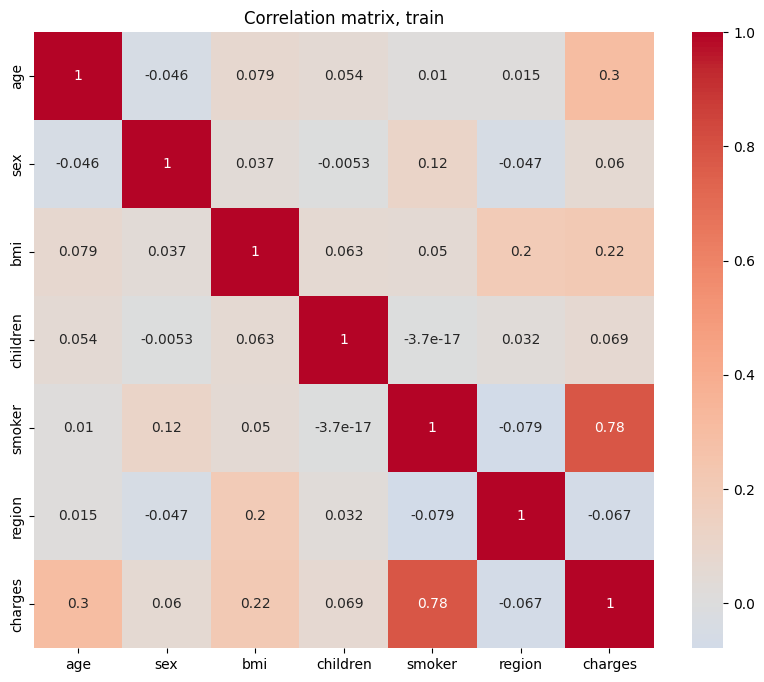

Correlations with targ (charges), train:
charges     1.000000
smoker      0.783519
age         0.298395
bmi         0.219566
children    0.069444
sex         0.060221
region     -0.066712
Name: charges, dtype: float64


In [ ]:
# Correlations between pairs (TRAIN ONLY BLYAT!!!)
plt.figure(figsize=(10, 8))
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation matrix, train')
plt.show()

print("Correlations with targ (charges), train:")
print(correlation_matrix['charges'].sort_values(ascending=False))

# 2) Linear regression

In [ ]:
X_train = train_df.drop('charges', axis=1)
y_train = train_df['charges']

X_test = test_df.drop('charges', axis=1)
y_test = test_df['charges']

# Intercept => +1 col with 1s
X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]
X_test_with_intercept = np.c_[np.ones(X_test.shape[0]), X_test]

print(f"Train size: {X_train_with_intercept.shape}")
print(f"Test size: {X_test_with_intercept.shape}")

Train size: (338, 7)
Test size: (1000, 7)


In [ ]:
# Anal: normal equation (LSQ shortcut for polynoms)
class LinearRegressionAnalytical:
    def __init__(self):
        self.weights = None

    def fit(self, X, y):
        # X * w = y
        # (X^T * X * w)^-1    = (X^T * y)^-1
        # w^-1 * (X^T * X)^-1 = (X^T * y)^-1
        #               w^-1  = (X^T * y)^-1 * (X^T * X)
        #               w     = (X^T * X)^-1 * (X^T * y)
        self.weights = np.linalg.inv(X.T @ X) @ X.T @ y
        return self

    def predict(self, X):
        return X @ self.weights

    def get_weights(self):
        return self.weights

# Train
lr_analytical = LinearRegressionAnalytical()
lr_analytical.fit(X_train_with_intercept, y_train)
y_pred_analytical = lr_analytical.predict(X_test_with_intercept)

mse_analytical = mean_squared_error(y_test, y_pred_analytical)
print(f"MSE, anal: {mse_analytical:.2f}")
print(f"Weights: {lr_analytical.get_weights()}")

MSE, anal: 34193641.48
Weights: [-11061.52122931    257.350529     -669.11655446    338.72760072
    482.45420394  23400.46492847   -549.00930538]


Iteration 0, Loss: 195151800.5082
Iteration 100, Loss: 143866620.9607
Iteration 200, Loss: 143078174.1927
Iteration 300, Loss: 142302121.4008
Iteration 400, Loss: 141536444.3725
Iteration 500, Loss: 140780803.8076
Iteration 600, Loss: 140034921.0875
Iteration 700, Loss: 139298530.1480
Iteration 800, Loss: 138571375.5905
Iteration 900, Loss: 137853212.1762
Iteration 1000, Loss: 137143804.3808
Iteration 1100, Loss: 136442925.9700
Iteration 1200, Loss: 135750359.5940
Iteration 1300, Loss: 135065896.4006
Iteration 1400, Loss: 134389335.6645
Iteration 1500, Loss: 133720484.4343
Iteration 1600, Loss: 133059157.1940
Iteration 1700, Loss: 132405175.5409
Iteration 1800, Loss: 131758367.8765
Iteration 1900, Loss: 131118569.1121
Iteration 2000, Loss: 130485620.3869
Iteration 2100, Loss: 129859368.7991
Iteration 2200, Loss: 129239667.1486
Iteration 2300, Loss: 128626373.6915
Iteration 2400, Loss: 128019351.9048
Iteration 2500, Loss: 127418470.2621
Iteration 2600, Loss: 126823602.0197
Iteration 270

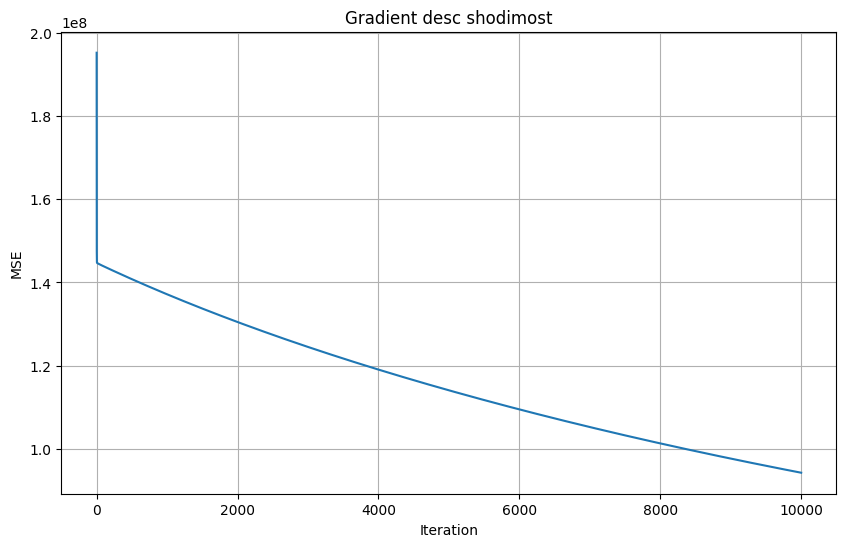

In [ ]:
class LinearRegressionGradientDescent:
    def __init__(self, learning_rate=0.001, max_iter=1000, tol=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.loss_history = []

    def compute_loss(self, X, y, weights):
        predictions = X @ weights
        return np.mean((predictions - y) ** 2)

    def compute_gradient(self, X, y, weights):
        predictions = X @ weights
        error = predictions - y
        gradient = (2 / len(y)) * (X.T @ error)
        return gradient

    def fit(self, X, y):
        self.weights = np.random.normal(0, 0.1, X.shape[1])

        for i in range(self.max_iter):
            gradient = self.compute_gradient(X, y, self.weights)

            new_weights = self.weights - self.learning_rate * gradient

            if np.linalg.norm(new_weights - self.weights) < self.tol:
                print(f"Completed at iteration {i}")
                break

            self.weights = new_weights

            loss = self.compute_loss(X, y, self.weights)
            self.loss_history.append(loss)

            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss:.4f}")

        return self

    def predict(self, X):
        return X @ self.weights

    def get_weights(self):
        return self.weights


lr_gd = LinearRegressionGradientDescent(learning_rate=0.0001, max_iter=10000)
lr_gd.fit(X_train_with_intercept, y_train)
y_pred_gd = lr_gd.predict(X_test_with_intercept)

mse_gd = mean_squared_error(y_test, y_pred_gd)
print(f"MSE, gradient descent {mse_gd:.2f}")
print(f"Model weights: {lr_gd.get_weights()}")

plt.figure(figsize=(10, 6))
plt.plot(lr_gd.loss_history)
plt.title('Gradient desc shodimost')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

# 3) Regularization

In [ ]:
# Ridge
class RidgeRegressionAnalytical:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.weights = None

    def fit(self, X, y):
        # w = (X^T * X + alpha * I)^-1 * X^T * y
        n_features = X.shape[1]
        identity_matrix = np.eye(n_features)
        identity_matrix[0, 0] = 0

        self.weights = np.linalg.inv(X.T @ X + self.alpha * identity_matrix) @ X.T @ y
        return self

    def predict(self, X):
        return X @ self.weights

    def get_weights(self):
        return self.weights

# Train
ridge_analytical = RidgeRegressionAnalytical(alpha=10.0)
ridge_analytical.fit(X_train_with_intercept, y_train)
y_pred_ridge_analytical = ridge_analytical.predict(X_test_with_intercept)

mse_ridge_analytical = mean_squared_error(y_test, y_pred_ridge_analytical)
print(f"MSE, Ridge regression (anal): {mse_ridge_analytical:.2f}")
print(f"Weights: {ridge_analytical.get_weights()}")

MSE, Ridge regression (anal): 36758978.39
Weights: [-10761.90954982    258.68528408   -307.94161638    351.96591694
    471.23353162  19988.82808382   -644.92318227]


Iteration 0, Loss: 195133559.6985
Iteration 100, Loss: 143913070.2231
Iteration 200, Loss: 143136666.0736
Iteration 300, Loss: 142380256.0692
Iteration 400, Loss: 141641746.9621
Iteration 500, Loss: 140920660.6252
Iteration 600, Loss: 140216574.0619
Iteration 700, Loss: 139529079.7939
Iteration 800, Loss: 138857785.2305
Iteration 900, Loss: 138202312.2186
Iteration 1000, Loss: 137562296.4532
Iteration 1100, Loss: 136937386.8832
Iteration 1200, Loss: 136327245.1373
Iteration 1300, Loss: 135731544.9745
Iteration 1400, Loss: 135149971.7600
Iteration 1500, Loss: 134582221.9636
Iteration 1600, Loss: 134028002.6808
Iteration 1700, Loss: 133487031.1760
Iteration 1800, Loss: 132959034.4451
Iteration 1900, Loss: 132443748.7988
MSE Ridge regression (grad desc): 115524670.43
Weights: [-103.69994788  214.52004796  101.19047702  206.6028021   149.0150896
 1585.13241547 -516.42280518]


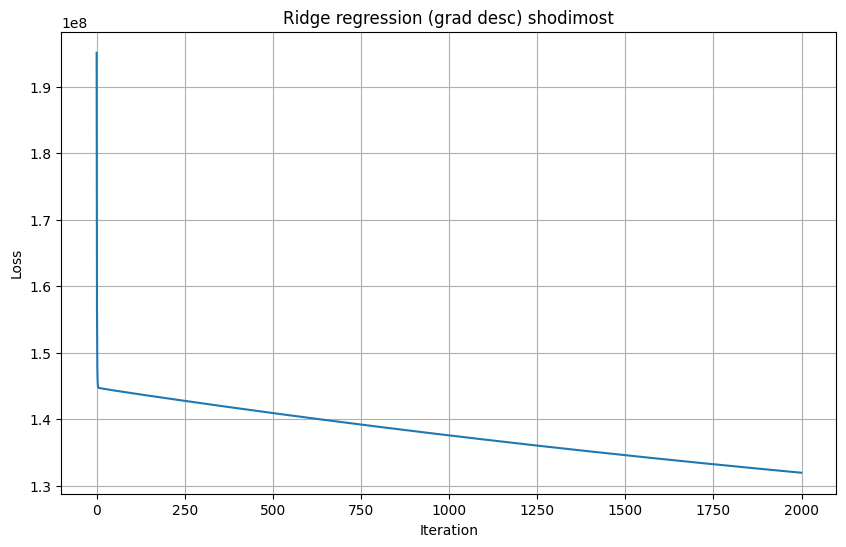

In [ ]:
# Grad desc, regularization
class RidgeRegressionGradientDescent:
    def __init__(self, alpha=1.0, learning_rate=0.001, max_iter=1000, tol=1e-6):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.loss_history = []

    def compute_loss(self, X, y, weights):
        predictions = X @ weights
        mse = np.mean((predictions - y) ** 2)
        regularization = self.alpha * np.sum(weights[1:] ** 2)
        return mse + regularization

    def compute_gradient(self, X, y, weights):
        predictions = X @ weights
        error = predictions - y
        gradient = (2 / len(y)) * (X.T @ error)
        gradient[1:] += 2 * self.alpha * weights[1:] / len(y)
        return gradient

    def fit(self, X, y):
        self.weights = np.random.normal(0, 0.1, X.shape[1])

        for i in range(self.max_iter):
            gradient = self.compute_gradient(X, y, self.weights)

            new_weights = self.weights - self.learning_rate * gradient

            if np.linalg.norm(new_weights - self.weights) < self.tol:
                print(f"Solution reached at iteration {i}")
                break

            self.weights = new_weights

            loss = self.compute_loss(X, y, self.weights)
            self.loss_history.append(loss)

            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss:.4f}")

        return self

    def predict(self, X):
        return X @ self.weights

    def get_weights(self):
        return self.weights


ridge_gd = RidgeRegressionGradientDescent(alpha=0.5, learning_rate=0.0001, max_iter=2000)
ridge_gd.fit(X_train_with_intercept, y_train)
y_pred_ridge_gd = ridge_gd.predict(X_test_with_intercept)

mse_ridge_gd = mean_squared_error(y_test, y_pred_ridge_gd)
print(f"MSE Ridge regression (grad desc): {mse_ridge_gd:.2f}")
print(f"Weights: {ridge_gd.get_weights()}")

plt.figure(figsize=(10, 6))
plt.plot(ridge_gd.loss_history)
plt.title('Ridge regression (grad desc) shodimost')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 4) Estimating generalization

Models on test:
                          Модель           MSE
1        Linear regression (LSQ)  3.419364e+07
3         Ridge regression (LSQ)  3.675898e+07
2  Linear regression (grad desc)  8.332796e+07
4   Ridge regression (grad desc)  1.155247e+08
0                   Const (mean)  1.418301e+08


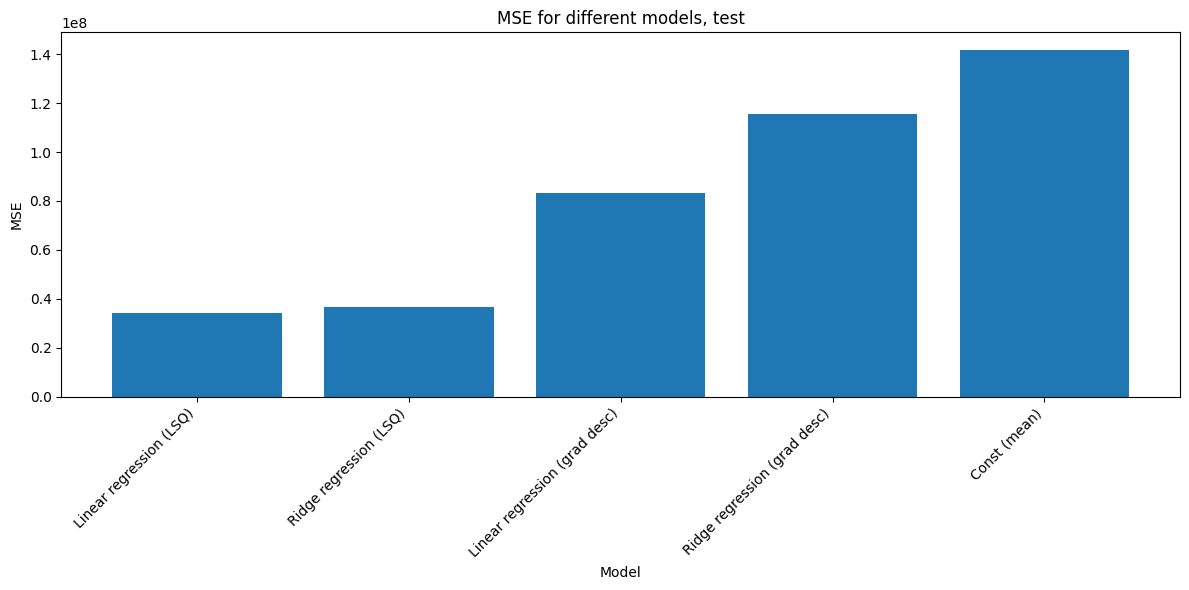

In [ ]:
# Const (mean from train)
y_pred_constant = np.full_like(y_test, y_train.mean())
mse_constant = mean_squared_error(y_test, y_pred_constant)

# Other models
models_comparison = pd.DataFrame({
    'Модель': ['Const (mean)', 'Linear regression (LSQ)',
               'Linear regression (grad desc)', 'Ridge regression (LSQ)',
               'Ridge regression (grad desc)'],
    'MSE': [mse_constant, mse_analytical, mse_gd, mse_ridge_analytical, mse_ridge_gd]
})

print("Models on test:")
print(models_comparison.sort_values('MSE'))

plt.figure(figsize=(12, 6))
models_comparison_sorted = models_comparison.sort_values('MSE')
plt.bar(models_comparison_sorted['Модель'], models_comparison_sorted['MSE'])
plt.title('MSE for different models, test')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

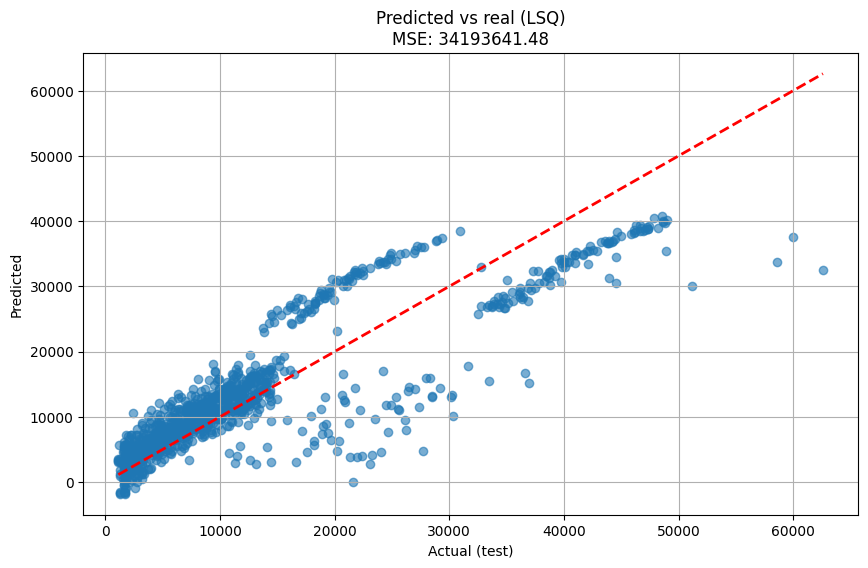

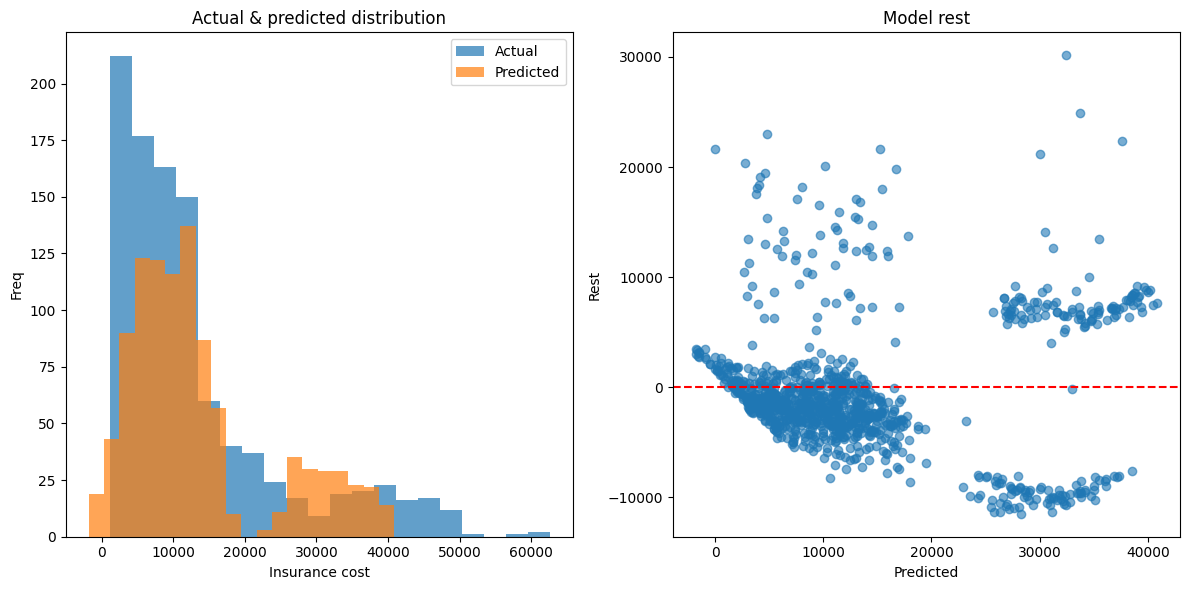

In [ ]:
# Predicted vs actual
best_model_idx = np.argmin([mse_analytical, mse_gd, mse_ridge_analytical, mse_ridge_gd])
best_models = [lr_analytical, lr_gd, ridge_analytical, ridge_gd]
best_model_names = ['LSQ', 'Grad desc', 'Ridge LSQ', 'Ridge Grad Desc']

best_model = best_models[best_model_idx]
best_model_name = best_model_names[best_model_idx]
y_pred_best = best_model.predict(X_test_with_intercept)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual (test)')
plt.ylabel('Predicted')
plt.title(f'Predicted vs real ({best_model_name})\nMSE: {models_comparison_sorted.iloc[0]["MSE"]:.2f}')
plt.grid(True)
plt.show()

# Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(y_test, alpha=0.7, label='Actual', bins=20)
plt.hist(y_pred_best, alpha=0.7, label='Predicted', bins=20)
plt.xlabel('Insurance cost')
plt.ylabel('Freq')
plt.title('Actual & predicted distribution')
plt.legend()

plt.subplot(1, 2, 2)
residuals = y_test - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Rest')
plt.title('Model rest')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

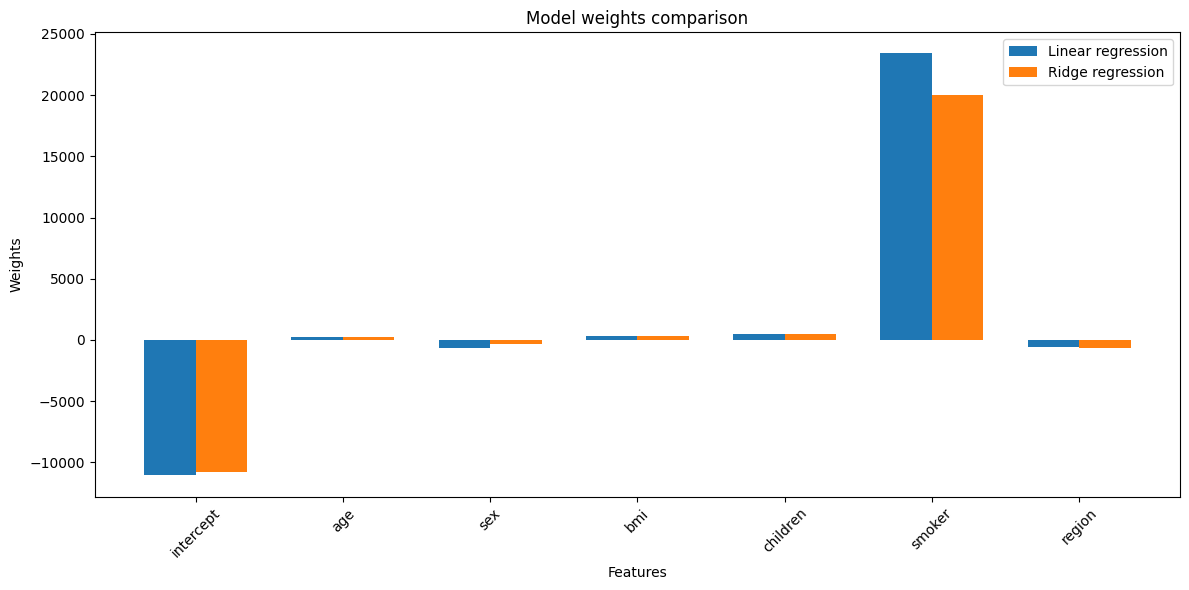

In [ ]:
# Features importance
feature_names = ['intercept'] + list(X_train.columns)

plt.figure(figsize=(12, 6))
weights_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight, LSQ': lr_analytical.get_weights(),
    'Weight, Ridge LSQ': ridge_analytical.get_weights()
})

x = np.arange(len(feature_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, weights_df['Weight, LSQ'], width, label='Linear regression')
rects2 = ax.bar(x + width/2, weights_df['Weight, Ridge LSQ'], width, label='Ridge regression')

ax.set_xlabel('Features')
ax.set_ylabel('Weights')
ax.set_title('Model weights comparison')
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()